# Run From Directories Example

In [1]:

import matplotlib.pyplot as plt
from sqlmodel import Session, create_engine, select

from cali.analysis import AnalysisRunner
from cali.detection import DetectionRunner
from cali.sqlmodel import (
    AnalysisSettings,
    DetectionSettings,
    Experiment,
    Traces,
    print_all_analysis_results,
    print_experiment_tree,
    print_experiment_tree_from_engine,
)

In [2]:
# path to the data and the segmentation labels
data_path = (
    "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/evk.tensorstore.zarr"
)
# path to save analysis results
analysis_path = "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/database"

In [3]:
# create a new experiment using the data in the specified directory
exp = Experiment.create_from_data(
    name="New Experiment",
    data_path=data_path,
    analysis_path=analysis_path,
    database_name="cali.db",
    experiment_type="Evoked Activity",
    plate_maps={
        "genotype": {"B5": "WT"},
        "treatment": {"B5": "Vehicle"},
    },
)
print_experiment_tree(exp)

🧪 New Experiment (ID: 0)
├── Experiment Type: Evoked Activity
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000 (fov: 0 - pos: 0)

In [4]:
# initialize the detection runner to run cellpose detection
detection = DetectionRunner()
# set cellpose detection settings
d_settings = DetectionSettings(method="cellpose", model_type="cpsam")
# run cellpose detection on the experiment on the specified position indices
detection.run_cellpose(exp, d_settings, global_position_indices=[0])


2025-11-19 14:11:15,545 - cali_logger - INFO - Use GPU: True
2025-11-19 14:11:15,546 - cali_logger - INFO - Loading model from `cpsam`.


2025-11-19 14:11:16,462 - cali_logger - INFO - 💾 Experiment analysis updated and saved to database at /Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/database/cali.db.
2025-11-19 14:11:16,466 - cali_logger - INFO - Loading images for batch processing...
2025-11-19 14:11:16,479 - cali_logger - INFO - Processing 1 images in batches of 8
Running Cellpose: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
2025-11-19 14:11:17,977 - cali_logger - INFO - ROIs detected: 4
2025-11-19 14:11:17,977 - cali_logger - INFO - Committing detection results to database...
2025-11-19 14:11:17,981 - cali_logger - INFO - ⚙️ Created new DetectionSettings ID 1


In [5]:
# visualize detected ROIs for the first FOV
engine = create_engine(f"sqlite:///{exp.db_path}")
print_experiment_tree_from_engine(exp.name, engine)

🧪 New Experiment (ID: 0)
├── Experiment Type: Evoked Activity
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000 (fov: 0 - pos: 0)
            ├── 🔬 ROI 1 (Detection Settings ID: 1)
            │   └── 🎭 ROI mask available
            ├── 🔬 ROI 2 (Detection Settings ID: 1)
            │   └── 🎭 ROI mask available
            ├── 🔬 ROI 3 (Detection Settings ID: 1)
            │   └── 🎭 ROI mask available
            └── 🔬 ROI 4 (Detection Settings ID: 1)
                └── 🎭 ROI mask available

In [6]:
# initialize the analysis runner to run activity analysis
analysis = AnalysisRunner()
# set analysis settings
a_settings = AnalysisSettings(threads=4, dff_window=10)
# run activity analysis on the experiment on the specified position indices
analysis.run(exp, a_settings, global_position_indices=[0])

2025-11-19 14:11:20,743 - cali_logger - INFO - 🔍 Using DetectionSettings ID 1 (method: cellpose)
2025-11-19 14:11:20,747 - cali_logger - INFO - ⚙️ Created new AnalysisSettings ID 1
2025-11-19 14:11:20,751 - cali_logger - INFO - 📊 Created AnalysisResult ID 1 (DetectionSettings=1, AnalysisSettings=1)
2025-11-19 14:11:20,772 - cali_logger - INFO - Extracting Traces Data from B5_0000.
Extracting Traces Data from B5_0000.:   0%|          | 0/4 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:849: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 153, using nperseg = 153
  ff, Pxx = scipy.signal.welch(y)
/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  

In [7]:
# visualize analysis results for this first run
print_all_analysis_results(engine, show_settings=False, max_experiment_level="roi")

All Analysis Results (1 result)
└── 📊 Analysis Result #1
    ├── 📍 Positions Analyzed (1 position)
    │   └── Position 0
    ├── ⚙️ Detection Settings (ID: 1)
    │   ├── 📅 Created: 2025-11-19 14:11:15.526991
    │   └── 🔬 Method: cellpose
    ├── ⚙️ Analysis Settings (ID: 1)
    │   └── 📅 Created: 2025-11-19 14:11:20.735525
    └── 🧪 Experiment (ID: 0)
        ├── Name: New Experiment
        ├── Type: Evoked Activity
        └── 📋 96-well (96-well)
            └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
                └── 📷 B5_0000 (fov: 0 - pos: 0)
                    ├── 🔬 ROI 1 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    ├── 🔬 ROI 2 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    ├── 🔬 ROI 3 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    └── 🔬 ROI 4 - 🔋 active - ✨ spontaneous
                        ├── 🎭 ROI mask available
                        ├── 📊 Trace data available
                        └── 📈 Data analysis available

In [8]:
# run analysis again with different settings
a_settings = AnalysisSettings(threads=4, dff_window=130)
# run activity analysis on the experiment on the specified position indices
analysis.run(exp, a_settings, global_position_indices=[0])

2025-11-19 14:11:27,065 - cali_logger - INFO - 🔍 Using DetectionSettings ID 1 (method: cellpose)
2025-11-19 14:11:27,070 - cali_logger - INFO - ⚙️ Created new AnalysisSettings ID 2
2025-11-19 14:11:27,074 - cali_logger - INFO - 📊 Created AnalysisResult ID 2 (DetectionSettings=1, AnalysisSettings=2)
2025-11-19 14:11:27,096 - cali_logger - INFO - Extracting Traces Data from B5_0000.
Extracting Traces Data from B5_0000.: 100%|██████████| 4/4 [00:00<00:00, 165.92it/s]
2025-11-19 14:11:27,131 - cali_logger - INFO - ✅ Completed AnalysisResult ID 2 (1 positions)


In [9]:
# visualize analysis results for all runs
print_all_analysis_results(engine, show_settings=False, max_experiment_level="roi")

All Analysis Results (2 results)
├── 📊 Analysis Result #1
│   ├── 📍 Positions Analyzed (1 position)
│   │   └── Position 0
│   ├── ⚙️ Detection Settings (ID: 1)
│   │   ├── 📅 Created: 2025-11-19 14:11:15.526991
│   │   └── 🔬 Method: cellpose
│   ├── ⚙️ Analysis Settings (ID: 1)
│   │   └── 📅 Created: 2025-11-19 14:11:20.735525
│   └── 🧪 Experiment (ID: 0)
│       ├── Name: New Experiment
│       ├── Type: Evoked Activity
│       └── 📋 96-well (96-well)
│           └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
│               └── 📷 B5_0000 (fov: 0 - pos: 0)
│                   ├── 🔬 ROI 1 - 🔋 active - ✨ spontaneous
│                   │   ├── 🎭 ROI mask available
│                   │   ├── 📊 Trace data available
│                   │   └── 📈 Data analysis available
│                   ├── 🔬 ROI 2 - 🔋 active - ✨ spontaneous
│                   │   ├── 🎭 ROI mask available
│                   │   ├── 📊 Trace data available
│                   │   └── 📈 Data analysis available
│                   ├── 🔬 ROI 3 - 🔋 active - ✨ spontaneous
│                   │   ├── 🎭 ROI mask available
│                   │   ├── 📊 Trace data available
│                   │   └── 📈 Data analysis available
│                   └── 🔬 ROI 4 - 🔋 active - ✨ spontaneous
│                       ├── 🎭 ROI mask available
│                       ├── 📊 Trace data available
│                       └── 📈 Data analysis available
└── 📊 Analysis Result #2
    ├── 📍 Positions Analyzed (1 position)
    │   └── Position 0
    ├── ⚙️ Detection Settings (ID: 1)
    │   ├── 📅 Created: 2025-11-19 14:11:15.526991
    │   └── 🔬 Method: cellpose
    ├── ⚙️ Analysis Settings (ID: 2)
    │   └── 📅 Created: 2025-11-19 14:11:27.057317
    └── 🧪 Experiment (ID: 0)
        ├── Name: New Experiment
        ├── Type: Evoked Activity
        └── 📋 96-well (96-well)
            └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
                └── 📷 B5_0000 (fov: 0 - pos: 0)
                    ├── 🔬 ROI 1 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    ├── 🔬 ROI 2 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    ├── 🔬 ROI 3 - 🔋 active - ✨ spontaneous
                    │   ├── 🎭 ROI mask available
                    │   ├── 📊 Trace data available
                    │   └── 📈 Data analysis available
                    └── 🔬 ROI 4 - 🔋 active - ✨ spontaneous
                        ├── 🎭 ROI mask available
                        ├── 📊 Trace data available
                        └── 📈 Data analysis available

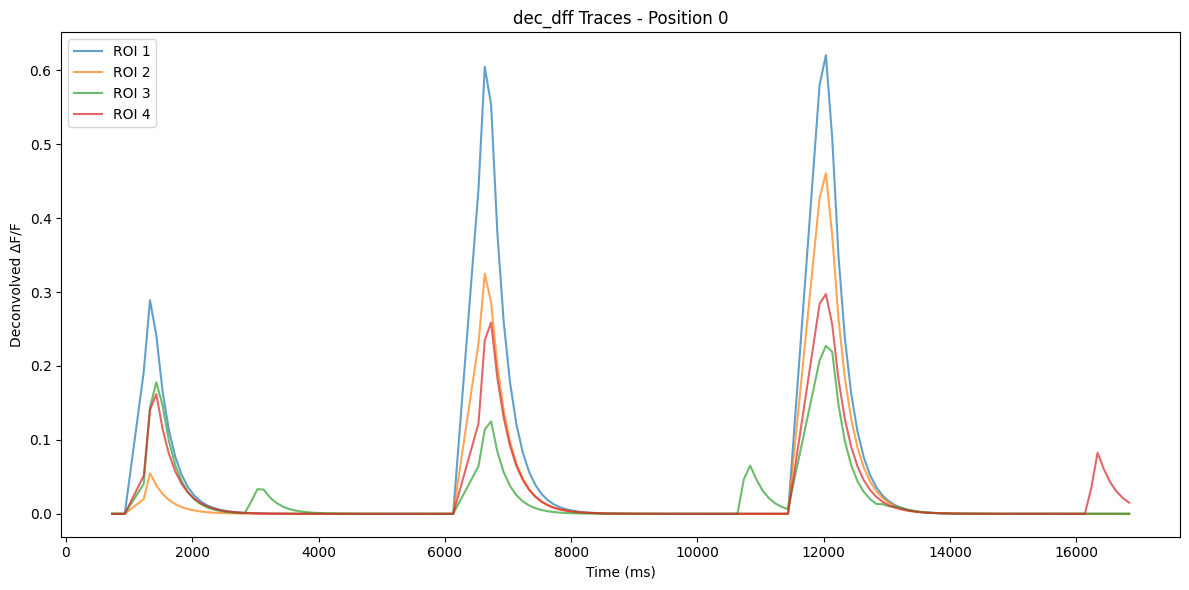

In [ ]:
# plot all raw traces by analysis_result_id
with Session(engine) as session:

    analysis_id = 1  # 1 or 2

    statement = select(Traces).where(Traces.analysis_result_id == analysis_id)

    traces_list = session.exec(statement).all()

    # Plot all dec_dff traces
    fig, ax = plt.subplots(figsize=(12, 6))

    for trace in traces_list:
        if trace.dec_dff is not None:
            # Use x_axis if available, otherwise use frame numbers
            x_data = (
                trace.x_axis
                if trace.x_axis is not None
                else list(range(len(trace.dec_dff)))
            )
            ax.plot(
                x_data,
                trace.dec_dff,
                label=f"ROI {trace.roi.label_value}",
                alpha=0.7,
            )

    x_label = "Time (ms)" if traces_list and traces_list[0].x_axis else "Frame"
    ax.set_xlabel(x_label)
    ax.set_ylabel("Deconvolved ΔF/F")
    ax.set_title("dec_dff Traces - Position 0")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()